## Experiment 6 : Auto Rate Fallback rate adaptation algorithm simulation for 802.11ax channel



### *1. Learning objectives*

• To create a multiuser (MU) very high efficiency (HE) format configuration object and initialize the
  transmit parameters for IEEE 802.11ax standard.

• To configure a TGax channel of 20 MHz bandwidth using wlanTGaxChannel system object.

• To pass the transmit waveform through the TGax channel and add AWGN to the transmit waveform.

• At the Receiver, doing Receiver processing- packet detection, symbol timing synchronization, channel estimation, equalization, and
  demodulation.

• To vary Modulation and coding scheme (MCS) according AARF rate adaptation algorithm.

### *2. Introduction*

#### Auto Rate Fallback (ARF) rate adaptation


• The IEEE 802.11 standard does not define any standardized rate adaptation algorithm
  (RAA) for dynamically varying the modulation rate.

• The implementation of RAA is left open to the WLAN device manufacturers.

• ARF is a open-loop rate adaptation algorithm(ARF does not depend on the feedback from the receiver to the transmitter)

• ARF was the first rate adaptation algorithm to be published. It was designed to optimize the application throughput in WaveLan II devices,    which implemented the 802.11 DSSS standard.

#### • ARF Algorithm

##### • In ARF, each sender attempts to use a higher transmission rate after a fixed number of successful transmissions at a given rate and switches back to a lower rate after 1 or 2 consecutive failures.

    -Let's say currently the transmitter is sending at rate in CSCM it can be 01 whatever.After say number of successful transmissions say it is set to 10.
    this transmitter will get to know whether this packet which is being transmitted is decoded successfully at the receiver or not through the acknowledgements.
    -If the transmitter gets 10 successive positive acknowledgements, then the sender will transmit the next packet with an MCSM + 1.
    -If previously if the MCS was say 2, after 10 successful transmissions then MCS will be increased by one that means for the 11th packet MCS will be 3.

    -When will the rate decrease? let's say there are  2 consecutive failures at any packet number once it has increased from 2 to 3 after 10 successful
    transmissions. Say after 5 packets, 5th and 6th packet failed after increase in the MCS from three 2 to 3, then the MCS again switches back the MCS by reducing
    by one that is, MCS decrease to 3 from 2.

##### • Specifically, the original ARF algorithm decreases the current rate and start a timer when two consecutive transmissions fail in a row. When either the timer expires or the number of successfully received per-packet acknowledgments reaches 10, the transmission rate is increased to a higher data rate and the timer is reset.

##### • When the rate is increased, the first transmission after the rate increase (commonly referred to as the probing transmission or probing packet) must succeed or the rate is immediately decreased and the timer is restarted rather than trying the higher rate a second time.
    -The algorithm basically depends upon the acknowledgement feedback and if they seize 10 consecutive positive acknowledgement that the MCS is increased by 1 
    and if the immediate packet that the probing packet if it fails again, MCS decreases by 1 and during transmission we know anytime if there are two consecutive
    failures then again MCS decreases by 1.

<img src="Expt6_ARF.jpg" style="width:1800px;height:300px" title="Expt6_ARF"/>

##### This schemme suffers from two problems:

##### 1.If the channel conditions change very quickly, it cannot adapt effectively. For example, in an adhoc network where the interference bursts are generated by other 802.11 packet transmissions, the optimum rate changes from one packet to the next. Because ARF requires 1 or 2 packet failures to decrease its rate and up to 10 successful packet transmission to increase it, it will never be synchronized with the sub-packet channel condition changes.
    -When the channel is varying quickly and if the SNR is increased, it may not quickly adapt to the increased channel SNR or channel condition that means whenever
    the channel changes back to good state it takes some time to sense channel condition and if the channel conditions do not change at all.

##### 2.If the channel conditions do not change at all, or change very slowly, it will try to use a higher rate every 10 successfully transmitted packets; this results in increased retransmission attempts and thus decreases the application throughput.

    -If it varies slowly, channel condition is not changing but still it will try to increase the MCS for every 10 packets and hence decreases application level
    throughput. Also ARF cannot estimate the sub packet channel condition changes.

<img src="Expt6_ARF_Ref.png" style="width:1800px;height:350px" title="Expt6_ARF_Ref"/>

• Sinusoidal curve : A variation of SNR at the reciever.

• Circle point : A successful data frame transmission.

• Cross point : A erroneous data frame transmission.

-After 10 successful packets, so it is increasing but the packet failed so immediately it came back to the original MCS. Again after 10 successful transmission it increased but now the channel is good. After 10 successful transmission, you try to again increase MCS packet fail. One thing to note is, time required for the transmission of packet is smaller.

### *3. Results*

<img src="Expt6_RU_allocation.png" style="width:1500px;height:500px" title="Expt6_RU_Details"/>

When you run the main program, you can see the allocation info. The showAllocation() will show what is the allocation for the given allocation index. Note only one user is occupying entire 242 subcarriers. The bandwidth is 2MHz having 256 subcarriers but the occupied subcarriers are 242, leaving this null subcarriers, DC subcarrier the card subcarriers. Actually it is an OFDMA mode, but single user is occupying the entire bandwidth.
Allocation information will be displayed when code is run. The data payload length is set of 100 bytes.

<img src="Expt6_snrWalk.png" style="width:1800px;height:500px" title="Expt6_SNR_Walk"/>

You can control mean SNR and the amplitude, if you set the mean SNR value to lower and if you increase the amplitude maybe the variation is more. Accordingly the SNR will change and if walkSNR is false then simply SNR walk is constant 25 DB and all the variability in the SNR comes from the slowly varying.

#### Simulation for 200 Packets

<img src="Expt6_TPut_200P.png" style="width:1800px;height:650px" title="Expt6_TPut_200P"/>

#### Simulation for 2000 Packets

<img src="Expt6_Tput_2000_pkts_ARF.png" style="width:1800px;height:650px" title="Expt6_TPut_2000P"/>

### *4. Code*

Let us just define the functions that are used in the main program. The below code is for ARF algorithm implementation.

In [7]:
%%file Expt6_rateAdaptationARF1.m
classdef Expt6_rateAdaptationARF1 < handle
%rateAdaptationARF Auto rate fallback (ARF) algorithm
%   CFG = rateAdaptationARF(NUMSTATIONS) creates an auto rate fallback
%   (ARF) object. This object provides functionality for ARF algorithm.
%
%   NUMSTATIONS must be a scalar double value specifying the number of
%   stations in the network.
%
%   CFG = rateAdaptationARF(...,Name,Value) creates an auto rate fallback
%   (ARF) object, CFG, with the specified property Name set to the
%   specified Value. You can specify additional name-value pair arguments
%   in any order as (Name1,Value1, ...,NameN,ValueN).
%
%   rateAdaptationARF properties:
%   SuccessThreshold - Successful transmission threshold for rate increment
%   FailureThreshold - Failure transmission threshold for rate decrement
%
%   rateAdaptationARF methods:
%   getRate         - Return a rate for frame transmission
%   updateStatus    - Update status of frame transmission
    
%   Copyright 2020 The MathWorks, Inc.

%#codegen

    properties
        % Number of successful transmissions after which rate is increased.
        %   Specify the value as a scalar integer. The default is 10.
%         SuccessThreshold(1,1) {mustBeNumeric, mustBeInteger} = 10;
            SuccessThreshold= 10;
        
        % Number of transmission failures after which rate is decreased
        %   Specify the value as a scalar integer. The default is 2.
%         FailureThreshold(1,1) {mustBeNumeric, mustBeInteger} = 2;
             FailureThreshold= 2;
    end
    
    properties(Access = private)
        % Current data rate index used for a receiving station
        CurrentRateIdx;
        
        % Flag indicating that the previous transmission status incremented the current rate
        PrevIncrementFlag;% this is a flag, setting high for a probe packet!
        
        % Count for consecutive successful transmissions
        ConsecutiveSuccessCount;
        
        % Count for consecutive transmission failures
        ConsecutiveFailureCount;
    end
    
    methods(Access = private)
        function newrateidx = incrementRate(~, oldrateidx)
            % Keep the same rate if the old rate is the maximum rate
            if oldrateidx == 9
                newrateidx = oldrateidx;
            else % if the old rate is not the maximum rate
                % Increment the rate
                newrateidx = oldrateidx+1;
            end
        end
        
        function newrateidx = decrementRate(~, oldrateidx)
            % Keep the same rate if the old rate is the minimum rate
            if oldrateidx == 0
                newrateidx = oldrateidx;
            else % if the old rate is not the minimum rate
                % Decrement the rate
                newrateidx = oldrateidx-1;
            end
        end
    end
    
    methods
        function obj = Expt6_rateAdaptationARF1(numStations, varargin)
        % Constructor method
            
            numNVpair = numel(varargin);
            coder.internal.errorIf((mod(numNVpair, 2)~=0), 'wlan:ConfigBase:InvalidPVPairs');
            validateattributes(numStations, {'numeric'}, {'scalar', 'positive', 'integer'}, mfilename, '');
            propertySet = {'SuccessThreshold', 'FailureThreshold'};
            for i = 1:2:numNVpair
                validatestring(varargin{i}, propertySet, mfilename);
                obj.(char(varargin{i})) = varargin{i+1};
            end
            
            obj.CurrentRateIdx = zeros(1, numStations);
            obj.PrevIncrementFlag = zeros(1, numStations);
            obj.ConsecutiveSuccessCount = zeros(1, numStations);
            obj.ConsecutiveFailureCount = zeros(1, numStations);
        end
        
        function rate = getRate(obj, rxStationIdx)
        %getRate Get a transmission data rate
        %   RATE = getRate(OBJ, RXSTATIONIDX) returns the data rate, RATE,
        %   for transmitting a frame to a station with the node ID
        %   indicated by RXSTATIONIDX.
        
            % Since wlanNonHTConfig accepts rates in the form of indices,
            % returning the index instead of actual data rate
            rate = obj.CurrentRateIdx(rxStationIdx);
        end
        
        function updateStatus(obj, rxStationIdx, isFail)
        %updateStatus Update the transmission status
        %   updateStatus(OBJ, RXSTATIONIDX, ISFAIL) updates the
        %   transmission status indicated by the flag ISFAIL for a
        %   receiving station with node ID, RXSTATIONIDX.
        
            % Transmission failure
            if isFail
                obj.ConsecutiveFailureCount(rxStationIdx) = obj.ConsecutiveFailureCount(rxStationIdx) + 1;
                obj.ConsecutiveSuccessCount(rxStationIdx) = 0;
                
                % Decrement the data rate if the transmission failed
                % immediately after incrementing the data rate, i.e., for  probe packet transmission
                if obj.PrevIncrementFlag(rxStationIdx)
                    obj.CurrentRateIdx(rxStationIdx) = obj.decrementRate(obj.CurrentRateIdx(rxStationIdx));
                    % Reset counters for the new rate
                    obj.ConsecutiveFailureCount(rxStationIdx) = 0;
                    obj.PrevIncrementFlag(rxStationIdx) = false;
                end
                
                % If the consectuive failure count reached threshold,
                % decrement data rate
                if (obj.ConsecutiveFailureCount(rxStationIdx) >= obj.FailureThreshold)
                    obj.CurrentRateIdx(rxStationIdx) = obj.decrementRate(obj.CurrentRateIdx(rxStationIdx));
                    % Reset counters for the new rate
                    obj.ConsecutiveFailureCount(rxStationIdx) = 0;
                end
                
            else % Successful transmission
                obj.ConsecutiveSuccessCount(rxStationIdx) = obj.ConsecutiveSuccessCount(rxStationIdx) + 1;
                obj.ConsecutiveFailureCount(rxStationIdx) = 0;
                
                % If the consecutive success count reached threshold,
                % increment data rate
                if (obj.ConsecutiveSuccessCount(rxStationIdx) >= obj.SuccessThreshold)
                    obj.CurrentRateIdx(rxStationIdx) = obj.incrementRate(obj.CurrentRateIdx(rxStationIdx));
                    obj.PrevIncrementFlag(rxStationIdx) = true;  % this flag is set only for the probingpacket 
                    %i.e., immediately after incrementing the data rate
                    % Reset counters for the new rate
                    obj.ConsecutiveSuccessCount(rxStationIdx) = 0;
                end
            end
        end
    end
end

Created file 'C:\Users\jioho\Documents\MATLAB\expt_6_with_helper_functions\Expt6_rateAdaptationARF1.m'.


#### Explanation:
The Expt6_rateAdaptationARF1 class implements the ARF algorithm for rate adaptation in wireless networks. It adjusts the transmission rate based on two thresholds: SuccessThreshold (10) for increasing the rate after consecutive successes and FailureThreshold (2) for decreasing the rate after failures. The class tracks the current rate, consecutive successes, and failures for each station. It includes methods to increment or decrement the rate, and updateStatus adjusts the rate based on transmission outcomes. The system dynamically adapts the rate to optimize performance in varying transmission conditions.

In [8]:
%%file Expt6_processPacket.m
function Y = Expt6_processPacket( txPSDU, txMUWave,snrWalk,tgaxChannel,cfgHEMU,numPkt,    numPacketErrors ,    ARF_algo)%%% processes a new packet every time

chanInfo = info(tgaxChannel);
pathFilters = chanInfo.ChannelFilterCoefficients; 
    % Pass the transmitted waveform through the channel, perform receiver processing, and SNR estimation.
  fs= wlanSampleRate(cfgHEMU);
    chanBW = cfgHEMU.ChannelBandwidth; % Channel bandwidth
    % Set the following parameters to empty for an undetected packet
    estimatedSNR = [];
    eqDataSym = [];
    noiseVarEst = [];
    rxPSDU = [];
    
      % Get the OFDM info of all RUs
    for ruNum = 1:numel(cfgHEMU.RU)          % ENABLED FOR MU-OFDMA
            ofdmInfo = wlanHEOFDMInfo('HE-Data',cfgHEMU,ruNum);
%          disp(ofdmInfo.NumTones);
    end
    numel(cfgHEMU.RU);
    % Pass the waveform through the fading channel model
[rxMUWave,pathgains] = tgaxChannel(txMUWave);%  received time-domain signal
      
    % Create an instance of the AWGN channel per SNR point simulated
    awgnChannel = comm.AWGNChannel;
    awgnChannel.NoiseMethod = 'Signal to noise ratio (SNR)';
        % Normalization
    awgnChannel.SignalPower = 1/tgaxChannel.NumReceiveAntennas; %% Signal power=1
    % Account for noise energy in nulls so the SNR is defined per
    % active subcarrier
    awgnChannel.SNR =snrWalk-10*log10(ofdmInfo.FFTLength/ofdmInfo.NumTones);
    %snrwalk varies for every packet. Therefore each packet has a different noise effect
  
   % Add noise
      [ rxMUWave] = awgnChannel(rxMUWave);%  adding AWGN to the received time-domain signal
      rx=rxMUWave;
      txMUWaveLength=size(txMUWave,1);% Length of the txed waveform
    rxWaveformLength = size(rxMUWave,1); % Length of the received waveform
        
    % Indices to extract fields from the PPDU
ind = wlanFieldIndices(cfgHEMU);

    % Get PERFECT timing offset and PERFECT channel matrix for HE-LTF field
    heltfPathGains = pathgains(ind.HELTF(1):ind.HELTF(2),:,:,:,:);
    pktOffset = helperPerfectTimingEstimate(heltfPathGains,pathFilters);
   
    chanBW = cfgHEMU.ChannelBandwidth; 
sr = wlanSampleRate(cfgHEMU); % Sample rate

% Create an HE recovery configuration object and set the channel bandwidth
cfgRx = wlanHERecoveryConfig;
cfgRx.ChannelBandwidth = chanBW;

% The recovery configuration object is used to get the start and end indices
%of the pre-HE-SIG-B field.
ind = wlanFieldIndices(cfgRx);
    
%% Packet Format Detection
% The time-domain samples equivalent to four OFDM symbols immediately
% following the L-LTF are used to determine the HE packet format [ <#16 1>
% Figure. 27-63]. The L-LTF is extracted and demodulated. For format
% detection, the demodulated L-LTF symbols must not include tone rotation
% for each 20 MHz segment as described in [ <#16 2> ], section 21.3.7.5.

% The demodulated L-LTF is used for channel and noise estimation. The L-LTF
% channel (without tone rotation) and noise power estimates are used to
% detect the packet format.

rxLLTF = rx(pktOffset+(ind.LLTF(1):ind.LLTF(2)),:);% extract LLTF from the received t-d waveform

% L-LTF Channel Estimate
% Demodulate the L-LTF and perform channel estimation. The demodulated
% L-LTF symbols include tone rotation for each 20 MHz segment as described
% in [ <#16 2> ], section 21.3.7.5. The L-LTF channel estimates (with tone
% rotation) are used to equalize and decode the pre-HE-LTF fields.

lltfDemod = wlanLLTFDemodulate(rxLLTF,chanBW);
lltfChanEst = wlanLLTFChannelEstimate(lltfDemod,chanBW);
noiseVar = helperNoiseEstimate(lltfDemod);

% Packet Format Detection using four OFDM symbols immediately following the L-LTF
% disp('Detect packet format...');
rxSIGA = rx(pktOffset+(ind.LSIG(1):ind.HESIGA(2)),:);
pktFormat = wlanFormatDetect(rxSIGA,lltfChanEst,noiseVar,chanBW);
% fprintf('  %s packet detected\n\n',pktFormat);

% Set the packet format in the recovery object and update the field indices
cfgRx.PacketFormat = pktFormat;
ind = wlanFieldIndices(cfgRx);

%% L-SIG and RL-SIG Decoding
% The L-SIG field is used to determine the receive time, or RXTIME, of the
% packet. The RXTIME is calculated using the length bits of the L-SIG
% payload. The L-SIG and RL-SIG fields are recovered to perform the channel
% estimate on the extra subcarriers in the L-SIG and RL-SIG fields. The
% |lltfChanEst| channel estimates are updated to include the channel
% estimates on extra subcarriers in the L-SIG and RL-SIG fields. The L-SIG
% payload is decoded using an estimate of the channel and noise power
% obtained from the L-LTF field. The L-SIG length property in
% <matlab:edit('wlanHERecoveryConfig.m') wlanHERecoveryConfig> is updated after L-SIG decoding.

% disp('Decoding L-SIG... ');
% Extract L-SIG and RL-SIG fields
rxLSIG = rx(pktOffset+(ind.LSIG(1):ind.RLSIG(2)),:);

% OFDM demodulate
helsigDemod = wlanHEDemodulate(rxLSIG,'L-SIG',chanBW);

% Estimate CPE and phase correct symbols
helsigDemod = preHECommonPhaseErrorTracking(helsigDemod,lltfChanEst,'L-SIG',chanBW);

% Estimate channel on extra 4 subcarriers per subchannel and create full
% channel estimate
preheInfo = wlanHEOFDMInfo('L-SIG',chanBW);
preHEChanEst = preHEChannelEstimate(helsigDemod,lltfChanEst,preheInfo.NumSubchannels);

% Average L-SIG and RL-SIG before equalization
helsigDemod = mean(helsigDemod,2);

% Equalize data carrying subcarriers, merging 20 MHz subchannels
[eqLSIGSym,csi] = preHESymbolEqualize(helsigDemod(preheInfo.DataIndices,:,:), ...
    preHEChanEst(preheInfo.DataIndices,:,:),noiseVar,preheInfo.NumSubchannels);

% Decode L-SIG field
[~,failCheck,lsigInfo] = wlanLSIGBitRecover(eqLSIGSym,noiseVar,csi);

% if failCheck
%     disp(' ** L-SIG check fail **');
% else
%     disp(' L-SIG check pass');
% end
% Get the length information from the recovered L-SIG bits and update the
% L-SIG length property of the recovery configuration object
lsigLength = lsigInfo.Length;
cfgRx.LSIGLength = lsigLength;

%% HE-SIG-A Decoding
% The HE-SIG-A field contains the transmission configuration of an HE
% packet. An estimate of the channel and noise power obtained from the
% L-LTF is required to decode the HE-SIG-A field.

% disp('Decoding HE-SIG-A...')
rxSIGA = rx(pktOffset+(ind.HESIGA(1):ind.HESIGA(2)),:);
sigaDemod = wlanHEDemodulate(rxSIGA,'HE-SIG-A',chanBW);
hesigaDemod = preHECommonPhaseErrorTracking(sigaDemod,preHEChanEst,'HE-SIG-A',chanBW);

% Equalize data carrying subcarriers, merging 20 MHz subchannels
preheInfo = wlanHEOFDMInfo('HE-SIG-A',chanBW);
[eqSIGASym,csi] = preHESymbolEqualize(hesigaDemod(preheInfo.DataIndices,:,:), ...
                                      preHEChanEst(preheInfo.DataIndices,:,:), ...
                                      noiseVar,preheInfo.NumSubchannels);
% Recover HE-SIG-A bits
[sigaBits,failCRC] = wlanHESIGABitRecover(eqSIGASym,noiseVar,csi);

% Perform the CRC on HE-SIG-A bits
% if failCRC
%     disp(' ** HE-SIG-A CRC fail **');
% else
%     disp(' HE-SIG-A CRC pass');
% end
%% Interpret Recovered HE-SIG-A bits
% The <matlab:edit('wlanHERecoveryConfig.m') wlanHERecoveryConfig> object
% is updated after interpreting the recovered HE-SIG-A bits. 

cfgRx = interpretHESIGABits(cfgRx,sigaBits);          
ind = wlanFieldIndices(cfgRx); % Update field indices

%% HE-SIG-B Decoding
% For an HE-MU packet the HE-SIG-B field contains:
%
% * The RU allocation information for a non-compressed SIGB waveform is
% inferred from HE-SIG-B Common field [ <#16 1> Table. 27-23]. For a
% compressed SIGB waveform the RU allocation information is inferred from
% the recovered HE-SIG-A bits.
% * For a non-compressed SIGB waveform the number of HE-SIG-B symbols are
% updated in the <matlab:edit('wlanHERecoveryConfig.m') wlanHERecoveryConfig> object. 
% The symbols are only updated if the number of HE-SIG-B symbols indicated
% in the HE-SIG-A field is set to 15 and all content channels pass the CRC.
% The number of HE-SIG-B symbols indicated in the HE-SIG-A field are not
% updated if any HE-SIG-B content channel fails the CRC.
% * The user transmission parameters for both SIGB compressed and
% non-compressed waveforms are inferred from the HE-SIG-B user field [ <#16 1>
% Table. 27-25, 27-26].
%
% An estimate of the channel and noise power obtained from the L-LTF is
% required to decode the HE-SIG-B field.

if strcmp(pktFormat,'HE-MU')
%     fprintf('Decoding HE-SIG-B...\n');
    if ~cfgRx.SIGBCompression
%         fprintf(' Decoding HE-SIG-B common field...\n');
        s = getSIGBLength(cfgRx);
        % Get common field symbols. The start of HE-SIG-B field is known
        rxSym = rx(pktOffset+(ind.HESIGA(2)+(1:s.NumSIGBCommonFieldSamples)),:);
        % Decode HE-SIG-B common field
        [status,cfgRx] = heSIGBCommonFieldDecode(rxSym,preHEChanEst,noiseVar,cfgRx);

        % CRC on HE-SIG-B content channels
%         if strcmp(status,'Success')
%             fprintf('  HE-SIG-B (common field) CRC pass\n');
%         elseif strcmp(status,'ContentChannel1CRCFail')
%             fprintf('  ** HE-SIG-B CRC fail for content channel-1\n **');
%         elseif strcmp(status,'ContentChannel2CRCFail')
%             fprintf('  ** HE-SIG-B CRC fail for content channel-2\n **');
%         elseif any(strcmp(status,{'UnknownNumUsersContentChannel1','UnknownNumUsersContentChannel2'}))
%             error('  ** Unknown packet length, discard packet\n **');
%         else
%             % Discard the packet if all HE-SIG-B content channels fail
%             error('  ** HE-SIG-B CRC fail **');
%         end
        % Update field indices as the number of HE-SIG-B symbols are
        % updated
        ind = wlanFieldIndices(cfgRx);
    end

    % Get complete HE-SIG-B field samples
    rxSIGB = rx(pktOffset+(ind.HESIGB(1):ind.HESIGB(2)),:);
%     fprintf(' Decoding HE-SIG-B user field... \n');
    % Decode HE-SIG-B user field
    [failCRC,cfgUsers] = heSIGBUserFieldDecode(rxSIGB,preHEChanEst,noiseVar,cfgRx);

    % CRC on HE-SIG-B users
    if ~all(failCRC)
%         fprintf('  HE-SIG-B (user field) CRC pass\n\n');
        numUsers = numel(cfgUsers);
    elseif all(failCRC)
        % Discard the packet if all users fail the CRC
        error('  ** HE-SIG-B CRC fail for all users **');
    else
%         fprintf('  ** HE-SIG-B CRC fail for at least one user\n **');
        % Only process users with valid CRC
        numUsers = numel(cfgUsers);
    end
    
else % HE-SU, HE-EXT-SU
    cfgUsers = {cfgRx};
    numUsers = 1;
end

    %% HE-Data Decoding for EACH USER
% The updated <matlab:edit('wlanHERecoveryConfig.m') wlanHERecoveryConfig>
% object for each user can then be used to recover the PSDU bits for each user in the HE-Data field.
% fprintf('Decoding HE-Data...\n');
% numUsers=1;  % disabled for decoding all the user's HE data. numUsers is obtained in the above part of the code


for iu = 1:numUsers % Get recovery configuration object for each user
    user = cfgUsers{iu};
%     if strcmp(pktFormat,'HE-MU')
%         fprintf(' Decoding User-ARF:%d, STAID:%d, RUSize:%d\n',iu,user.STAID,user.RUSize);
%     else
% %         fprintf(' Decoding RUSize:%d\n',user.RUSize);
%     end


    % HE-LTF demodulation and channel estimation  
    rxHELTF = rx(pktOffset+(ind.HELTF(1):ind.HELTF(2)),:);
    heltfDemod = wlanHEDemodulate(rxHELTF,'HE-LTF',chanBW,user.GuardInterval, ...
        user.HELTFType,[user.RUSize user.RUIndex]);%% user's RU size and RU index would fetch only
%     Channel estimates on that particular RU
    [chanEst,pilotEst] = heLTFChannelEstimate(heltfDemod,user);
    Channel_estimates_size=size(chanEst );
  
    % HE-Data demodulate
    rxData = rx(pktOffset+(ind.HEData(1):ind.HEData(2)),:); 
    demodSym = wlanHEDemodulate(rxData,'HE-Data',chanBW,user.GuardInterval, ...
        [user.RUSize user.RUIndex]);

    % Pilot phase tracking. Average single-stream pilot estimates over
    % symbols (2nd dimension)
    pilotEstTrack = mean(pilotEst,2);
    demodSym = heCommonPhaseErrorTracking(demodSym,pilotEstTrack,user);

    % Estimate noise power in HE fields
    heInfo = wlanHEOFDMInfo('HE-Data',chanBW,user.GuardInterval,[user.RUSize user.RUIndex]);
    demodPilotSym = demodSym(heInfo.PilotIndices,:,:);
    nVarEst = heNoiseEstimate(demodPilotSym,pilotEst,user);

    % Equalize
    [eqSym,csi] = heEqualizeCombine(demodSym,chanEst,nVarEst,user);

    % Discard pilot subcarriers
    eqSymUser = eqSym(heInfo.DataIndices,:,:);
    csiData = csi(heInfo.DataIndices,:);

    % Demap and decode bits
    rxPSDU = wlanHEDataBitRecover(eqSymUser,nVarEst,csiData,user,'LDPCDecodingMethod','layered-bp');
    noisePower=nVarEst;
 %%% To estimate the SNR in frequency domain using channel estimates H(K)
%  A1=mean(chanEst.*conj(chanEst));  Both of these are same!
% B1=mean(sum(chanEst.*conj(chanEst),2),'all');
% check(chanEst)
    chanPower(iu) = mean(sum(chanEst.*conj(chanEst),2),'all');
    length(chanEst);
    if chanPower(iu)>noisePower
estimatedSNR(iu) =10*log10 ((chanPower(iu)-noisePower)/noisePower);
    else
        estimatedSNR(iu) =-10;
    end
snrWalk;

    % Determine if any bits are in error, i.e. a packet error
    packetError = ~isequal(txPSDU{:,1},rxPSDU);
    perStore(numPkt) = packetError;
    numPacketErrors = numPacketErrors+packetError;
    updateStatus(ARF_algo, 1,  packetError);
    %   updateStatus    - Update status of frame transmission
end
 % Set output
   Y = struct( 'RxPSDU',  rxPSDU,  'EqDataSym',        eqDataSym,  'RxWaveformLength', rxWaveformLength,   'NoiseVar', noiseVarEst, 'EstimatedSNR_RU1',     estimatedSNR(1));

end



Created file 'C:\Users\jioho\Documents\MATLAB\expt_6_with_helper_functions\Expt6_processPacket.m'.


#### Explanation:
The processPacket function simulates the reception, processing, and decoding of wireless packets in an MU-MIMO (multi-user multiple input, multiple output) communication system, using a channel model and various modulation techniques. It begins by passing the transmitted waveform through a fading channel model to simulate real-world transmission conditions.

The function then applies noise via an AWGN (Additive White Gaussian Noise) channel, adjusting the signal-to-noise ratio (SNR) for each packet. It extracts key packet fields like L-LTF, L-SIG, HE-SIG-A, and HE-SIG-B for packet format detection, timing offset estimation, and channel estimation. The data from these fields is demodulated, decoded, and equalized. Channel conditions are analyzed through channel estimates, and the SNR is calculated based on the signal and noise power.

The function also checks for packet errors by comparing the received and transmitted payloads. If errors are detected, the error count is updated, and the ARF (Automatic Repeat Request) algorithm is applied to adjust transmission status. The final output consists of the received packet data, equalized symbols, estimated noise variance, and SNR for each user in the system.

In [9]:
%%file Expt6_plotResults.m
function Expt6_plotResults(ber,packetLength,snrMeasured,MCS,cfgHE)
    % Visualize simulation results
   figure('Outerposition',[50 50 900 700])
    subplot(4,1,1);
    plot(MCS);grid on;
ylim([0 12])
%     xlabel('Packet Number')
    ylabel('MCS')
  title('MCS')

    subplot(4,1,2);
    plot(snrMeasured); grid on;
    ylim([0 (max(snrMeasured)+1)])
%     xlabel('Packet Number')
    ylabel('SNR')
    title('Estimated SNR')
    
    subplot(4,1,3);
    plot(find(ber==0),ber(ber==0),'x') ;
    grid on;
    hold on; 
    stem(find(ber>0),ber(ber>0),'or') 
    if any(ber)
        legend('Successful decode','Unsuccessful decode') 
    else
        legend('Successful decode') 
    end
%     xlabel('Packet Number')
    ylabel('BER')
    title('Instantaneous bit error rate per packet')

    subplot(4,1,4);
    windowLength = 10; % Length of the averaging window
    movDataRate = movsum(8*cfgHE.User{1}.APEPLength.*(ber==0),windowLength)./movsum(packetLength,windowLength)/1e6;
    plot(movDataRate);grid on;
    ylim([0 (max(movDataRate)+1)])
    xlabel('Packet Number')
    ylabel('Mbps')
    title(sprintf('Throughput over last %d packets',windowLength))
  
end

Created file 'C:\Users\jioho\Documents\MATLAB\expt_6_with_helper_functions\Expt6_plotResults.m'.


In [10]:
%%file Expt6_function.m
%OWN code 802.11ax ARF Simulation coded on June 11, 2020
%uses rateAdaptationARF1.m to create an auto rate fallback (ARF) object. 
%This object provides functionality for ARF algorithm.
function [Overalldatarate, OverallPER,total_tx_time_arf,MCS,perStore, Packet_duration_ms]=Expt6_function(numPackets,snrWalk,cfgHEMU,tgaxChannel)
sr= wlanSampleRate(cfgHEMU);
fs=sr;

ARF_algo = Expt6_rateAdaptationARF1(1);
numPacketErrors =0;

% Define simulation variables
snrMeasured = zeros(1,numPackets);
MCS = zeros(1,numPackets);
ber = zeros(1,numPackets);
packetLength = zeros(1,numPackets);
Packet_duration_ms=zeros(1,numPackets);% Packet length in ms

for numPkt = 1:numPackets
    numPkt
     allocInfo = ruInfo(cfgHEMU); 
     % Generate a packet with random PSDU
        psduLength = getPSDULength(cfgHEMU); % % PSDU length in bytes, length changes every time depednding on the selected MCS!!!
           txPSDU = cell(1,allocInfo.NumUsers);  
for i = 1:allocInfo.NumUsers  %   allocInfo.NumUsers=9 here;
     txPSDU{i} = randi([0 1],psduLength(i)*8,1,'int8'); % Generate random PSDU
end
           
% Create MU packetpacket waveform %%% txwave changes every time, 
txMUWave = wlanWaveformGenerator(txPSDU{:,1},cfgHEMU,'IdleTime',5e-4);  %%% new packet every time
%  txMUWave = wlanWaveformGenerator(txPSDU{:,1},cfgHEMU); %without idle time

 MCS(numPkt) = cfgHEMU.User{1}.MCS; % Store current MCS value
  
    % Receive processing
    y = Expt6_processPacket( txPSDU,  txMUWave,snrWalk(numPkt),tgaxChannel,cfgHEMU,numPkt, numPacketErrors,    ARF_algo);  

    % Store estimated SNR value for each packet
    if isempty(y.EstimatedSNR_RU1) 
        snrMeasured(1,numPkt) = NaN;
    else
        snrMeasured(1,numPkt) = y.EstimatedSNR_RU1;
    end

    % Determine the length of the packet in seconds including idle time
    packetLength(numPkt) = y.RxWaveformLength/sr;
    Packet_duration_ms(numPkt)=    packetLength(numPkt) *1e3;

     % Calculate packet error rate (PER)
    if isempty(y.RxPSDU)
        % Set the PER of an undetected packet to NaN
        ber(numPkt) = NaN;
    else
        [Num_bit_errors(numPkt),ber(numPkt)] = biterr(y.RxPSDU,txPSDU{:,1});
           %BITERR Compute number of bit errors and bit error rate.
%   [NUMBER,RATIO] = BITERR(X,Y) 
    end
   
   newrateidx = getRate(ARF_algo, 1);% set new rate based on step up and fall back threshold values
    %   getRate         - Return a rate for frame transmission
   cfgHEMU.User{1}.MCS =newrateidx;
    MCS_transition_ARF=cfgHEMU.User{1}.MCS ;
EstimatedSNR=y.EstimatedSNR_RU1;  % this is unused in ARF! since it is independent of measured SNR
end

% Assume `ber` stores the packet error rate, assign it to `perStore`
perStore = ber;  

% Display and plot simulation results
Overalldatarate= (8*cfgHEMU.User{1}.APEPLength*(numPackets-numel(find(ber)))/sum(packetLength)/1e6) ;
OverallPER= (numel(find(ber))/numPackets);
disp(['Overall Data rate of ARF: ' num2str(Overalldatarate) ' Mbps'])
disp(['Overall PER of ARF : ' num2str(OverallPER)])
total_tx_time_arf=sum(packetLength);
disp(['Total transmission time_ARF: ' num2str(total_tx_time_arf*1e3) 'ms']);
% c =1     0     3     5     7     6     0     7     8     0
% find(c)=1     3     4     5     6     8     9
% numel(find(c))=7
Expt6_plotResults(ber,packetLength,snrMeasured,MCS,cfgHEMU);
end

Created file 'C:\Users\jioho\Documents\MATLAB\expt_6_with_helper_functions\Expt6_function.m'.


#### Explanation:
The Expt6_function simulates an 802.11ax ARF (Auto Rate Fallback) algorithm to adjust the transmission rate of MU-MIMO packets based on the packet error rate. It generates random PSDUs (Physical Layer Service Data Units) and transmits them over a wireless channel, calculating the signal-to-noise ratio (SNR), bit error rate (BER), and packet error rate (PER). The ARF algorithm adapts the modulation and coding scheme (MCS) based on the transmission outcome. The function calculates key metrics like the total data rate, packet error rate, and transmission time, providing insights into the performance of the ARF algorithm in an 802.11ax environment.

Below is the code for scenario_basic.m which is basically SNR work as already discussed in Expt-5.

In [11]:
%%file Expt6_scenario_basic.m
function[sw]=Expt6_scenario_basic(numPackets)
walkSNR =true; % Select SNR for the simulation

% Set random stream for repeatability of results
% s = rng(21);
if walkSNR
    %%% earlier this was set to 33 and 8
    meanSNR =34 ;   % Mean SNR, if increases reaches highest MCS upto MCS 9 ...................
    amplitude =4   ; % Variation in SNR around the average mean SNR value, if decreases , doesnot reach lower MCS..........
    % Generate varying SNR values for each transmitted packet
    baseSNR = sin(linspace(1,10,numPackets))*amplitude+meanSNR;
    snrWalk = baseSNR(1); % Set the initial SNR value
    % The maxJump controls the maximum SNR difference between one packet and the next 
    maxJump =0.5;
else
    % Fixed mean SNR value for each transmitted packet. All the variability
    % in SNR comes from a time varying radio channel
    snrWalk = 25; %SNR is constant at 25dB
end

sw=[];
for numPkt = 1:numPackets 
    if walkSNR
        % Generate SNR value per packet using random walk algorithm biased towards the mean SNR
        snrWalk = 0.9*snrWalk+0.1*baseSNR(numPkt)+rand(1)*maxJump*2-maxJump; 
        % Rxed SNR varies for every packet.
    end
     sw=[sw snrWalk];
end

figure();
plot(sw);hold on;grid on;
xlabel('Packet number')
  ylabel('SNR in dB')
 title('snrWalk')
mean(sw);
end


Created file 'C:\Users\jioho\Documents\MATLAB\expt_6_with_helper_functions\Expt6_scenario_basic.m'.


#### Explanation:
The function Expt6_scenario_basic generates a varying signal-to-noise ratio (SNR) profile for simulating a wireless communication system. It either generates a random walk of SNR values for each packet or uses a fixed SNR, depending on the walkSNR flag. The meanSNR and amplitude control the central value and variability of the SNR, respectively. For each packet, it adjusts the SNR either using a random walk (biased towards the mean SNR) or keeps it constant. The generated SNR values are plotted and the mean SNR is calculated. The function outputs the list of SNR values used in the simulation.

Below is the main program, Expt6_main.m

Allocation info:
                    NumUsers: 1
                      NumRUs: 1
                   RUIndices: 1
                     RUSizes: 242
               NumUsersPerRU: 1
    NumSpaceTimeStreamsPerRU: 1
       PowerBoostFactorPerRU: 1
                   RUNumbers: 1

 Packet Duration: 1.12       0.848       0.752       0.704       0.656        0.64       0.624       0.624       0.608       0.608 ms

numPkt =

     1


numPkt =

     2


numPkt =

     3


numPkt =

     4


numPkt =

     5


numPkt =

     6


numPkt =

     7


numPkt =

     8


numPkt =

     9


numPkt =

    10


numPkt =

    11


numPkt =

    12


numPkt =

    13


numPkt =

    14


numPkt =

    15


numPkt =

    16


numPkt =

    17


numPkt =

    18


numPkt =

    19


numPkt =

    20


numPkt =

    21


numPkt =

    22


numPkt =

    23


numPkt =

    24


numPkt =

    25


numPkt =

    26


numPkt =

    27


numPkt =

    28


numPkt =

    29


numPkt =

    30


numPkt =

    31




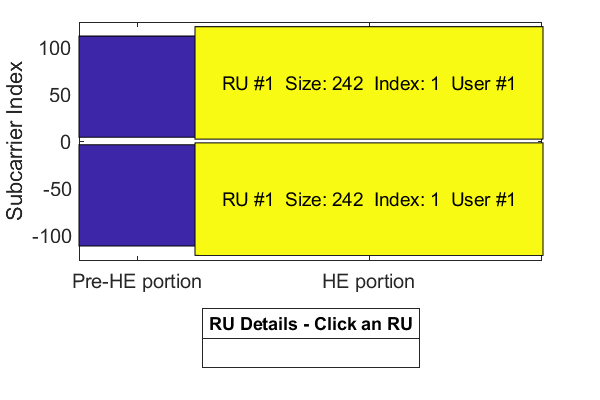

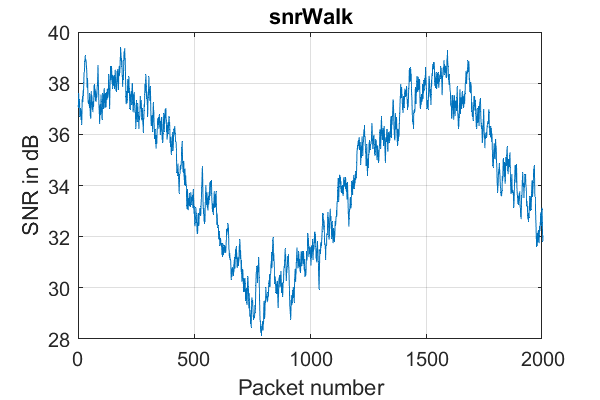

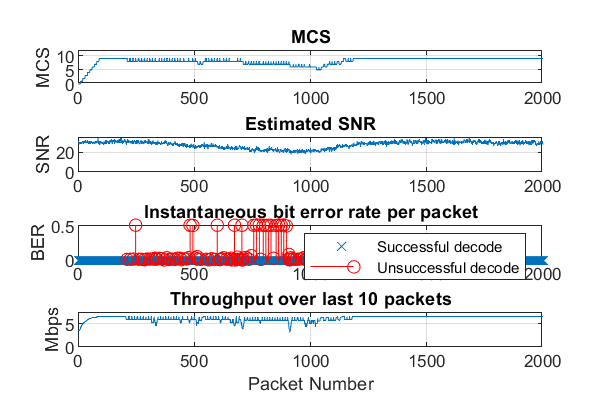

In [12]:
%  To run ARF for SU-OFDMA
clc;   
close all;         
clear all;                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

% Waveform configuration : configure properties
cfgMU = wlanHEMUConfig(192);    % allocation index is set to 192
%wlanHEMUConfig Create a multi-user high efficiency (HE) format configuration object
 showAllocation(cfgMU)

allocInfo = ruInfo(cfgMU);
disp('Allocation info:')
disp(allocInfo)
ind = wlanFieldIndices(cfgMU);
% Set the APEPLength of USER1 (SU active on RU1: MU-OFDMA)
    cfgMU.User{1}.APEPLength = 500;
    cfgMU.User{1}.MCS =0; %initially MCS is set to 0
    numPackets=2000;   %number of packets to simulate
sr = wlanSampleRate(cfgMU); %sampling rate

%to fetch the packet(size=500bytes) transmit duration for each MCS 0-9
%This part of the code just gives the packet duration for different MCS combination.
    Packet_duration=[];
for i = 1:10
    cfgMU.User{1}.MCS = i-1;
    psduLength = getPSDULength(cfgMU);% PSDU length in bytes, length changes every time depednding on the selected MCS!!!
    psduLength(10)=504; % in bytes
    txPSDU{i} = randi([0 1],psduLength(i)*8,1,'int8'); % Generate random PSDU
    txMUWave{i} = wlanWaveformGenerator(txPSDU{:,1},cfgMU,'IdleTime',5e-4);  %waveform generator generates OFD modulated symbols with the idle time
    duration = (length(txMUWave{i} )/sr)*1e3; 
  Packet_duration=[ Packet_duration  duration]; %in ms
end 
   disp([' Packet Duration: ' num2str(Packet_duration) ' ms']); 

   cfgMU.User{1}.MCS = 0; %% RESET initial MCS of User1 to 0 for rate adaptation
   
% Channel Configuration
tgaxChannel = wlanTGaxChannel;
tgaxChannel.DelayProfile = 'Model-D';
%   tgaxChannel.EnvironmentalSpeed=1.2;
tgaxChannel.ChannelBandwidth = cfgMU.ChannelBandwidth;
tgaxChannel.NumTransmitAntennas = 1;
tgaxChannel.NumReceiveAntennas = 1;
tgaxChannel.TransmitReceiveDistance =10; % Distance in meters for NLOS mode of propagation
tgaxChannel.SampleRate = 100e6;

% Set the sampling rate for the channel
sr= wlanSampleRate(cfgMU);
tgaxChannel.SampleRate = sr; %sampling rate is set
fs=sr;
tgaxChannel.PathGainsOutputPort = true;
tgaxChannel.NormalizeChannelOutputs = false;
tgaxChannel.RandomStream = 'mt19937ar with seed';% source of the random number stream. mt19937ar alogorithm generates normally distributed random numbers.
 tgaxChannel.Seed =0;% initial seed of the random number stream

    [sw]=Expt6_scenario_basic(numPackets); % snrWalk
% refer expt 5 for detailed explaination of snrWalk

[Overalldatarate_PER, OverallPER,total_tx_time_arf,MCS,status, Packet_duration_ms]=Expt6_function(numPackets,sw,cfgMU,tgaxChannel);  % ARF Algorithm   




#### Explanation:
The code simulates an 802.11ax MU-MIMO system using Auto Rate Fallback (ARF) for SU-OFDMA transmission. It configures the waveform and sets parameters for the MU-HE format, with an initial modulation and coding scheme (MCS) for a user. The simulation transmits 2000 packets, calculates packet durations for various MCS levels, and generates corresponding waveforms. A TGaxChannel model is configured for NLOS propagation. The ARF algorithm adjusts the MCS based on transmission success, optimizing data rates. Finally, the simulation outputs key metrics such as overall data rate, packet error rate, and total transmission time.